In [1]:
import numpy as np
import pandas as pd
from scipy.special import erf
from scipy.stats import norm
from scipy.stats import ncx2
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm

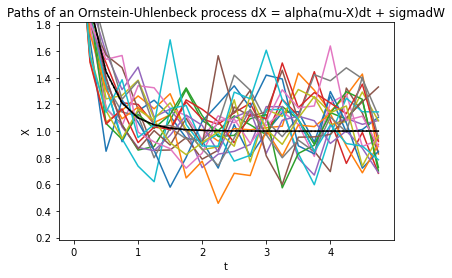

In [2]:
#Simulate an Ornstein-Uhlenbeck process
#dX = alpha*(mu-X)*dt + sigma*dW

#Define parameters and time grid
npaths=np.power(10,4)*2 #number of paths
T=5 #time horizon
nsteps=20 #number of time steps
dt=T/nsteps #time step
t=np.arange(0,T,dt) #observation times
alpha,mu,sigma=3,1,0.5 #model parameters
X0=3 #initial value

#Allocate and initialise all paths
X=[np.zeros(nsteps)]*npaths
X=np.insert(X,0,X0,axis=1)
X=np.delete(X,-1,axis=1)

#Sample standard Gaussian random numbers
N=np.random.randn(npaths,nsteps)

#Compute the standard deviation for a time step
#sdev = sigma*np.sqrt(dt) #plain Euler
sdev = sigma*np.sqrt((1-np.exp(-2*alpha*dt))/(2*alpha)) #Euler with analytic moments

#Compute and accumulate the increments
for i in range(npaths):
    for j in range(nsteps-1):
        #X[i][j+1]=X[i][j]+alpha*(mu-X[i][j])*dt+sdev*N[i][j]
        X[i][j+1]=mu+(X[i][j]-mu)*np.exp(-alpha*dt)+sdev*N[i][j] #Euler with a.m.

#Compute the expected path
EX=mu+(X0-mu)*np.exp(-alpha*t)

#Plot the expected, mean and sample paths
plt.figure(1)
df2=pd.concat([pd.Series(x) for x in X], axis=1)
mean_paths=df2.apply(lambda row: np.mean(row),axis=1)
for k in range(nsteps):
    plt.plot(t,X[k])
plt.plot(t,EX,'k',label='Expected path')
plt.plot(t,mean_paths,':k',label='Mean path')
plt.xlabel('t')
plt.ylabel('X')
sdevinfty = sigma/np.sqrt(2*alpha)
plt.ylim([mu-4*sdevinfty,mu+4*sdevinfty])
plt.title('Paths of an Ornstein-Uhlenbeck process dX = alpha(mu-X)dt + sigmadW')
plt.show()

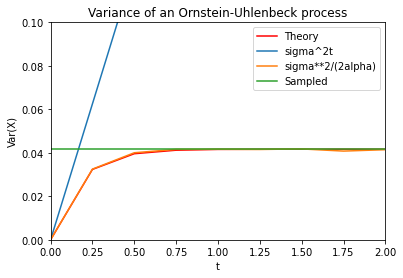

In [3]:
#Plot the variance
varian=sigma**2/(2*alpha)*(1-np.exp(-2*alpha*t))
var_path=df2.apply(lambda row: np.var(row),axis=1)
plt.figure(2)
plt.plot(t,varian,'r',t,sigma**2*t,t,var_path,t,sigma**2/(2*alpha)*np.ones(np.size(t)))
plt.legend(['Theory','sigma^2t','sigma**2/(2alpha)','Sampled'])
plt.ylim([0,0.1])
plt.xlim([0,2])
plt.xlabel('t')
plt.ylabel('Var(X)')
plt.title('Variance of an Ornstein-Uhlenbeck process')
plt.show()

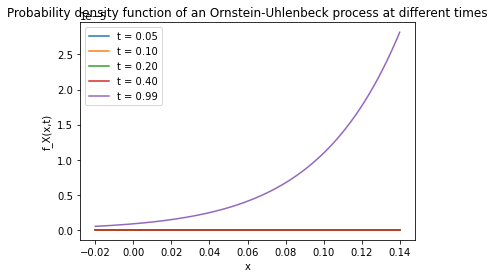

In [4]:
#Compute and plot the probability density function at different times
x=np.linspace(-0.02,0.14,200)
t2=[0.05,0.1,0.2,0.4,0.99]
EX2=np.zeros(len(t2))
for o in range(len(t2)):
    EX2[o]=np.exp(-alpha*t2[o])*X0+mu*(1-np.exp(-alpha*t2[o]))
sdev2=np.zeros(len(t2))
for p in range(len(t2)):
    sdev2[p]=sigma*np.sqrt((1-np.exp(-2*alpha*t2[p]))/(2*alpha))
f2 = [np.zeros(len(x))]*len(t2)
for q in range(len(t2)):
    f2[q] = norm.pdf(x,EX2[q],sdev2[q])
plt.figure(3)
for r in range(len(t2)):
    plt.plot(x,f2[r])
plt.xlabel('x')
plt.ylabel('f_X(x,t)')
plt.title('Probability density function of an Ornstein-Uhlenbeck process at different times')
plt.legend(['t = 0.05','t = 0.10','t = 0.20','t = 0.40','t = 0.99'])
plt.show()

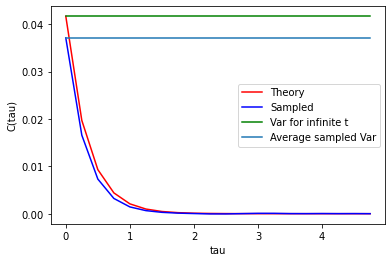

In [5]:
#Compute and plot the autocovariance function
C=[np.zeros(2*nsteps+1)]*npaths
for s in range(npaths):
    C[s]=(1/(nsteps+1))*np.correlate(X[s]-EX,X[s]-EX,mode=2)
dframe=pd.concat([pd.Series(x) for x in C],axis=1)
C2=dframe.apply(lambda row: np.mean(row),axis=1)
plt.figure(4)
plt.plot(t,sigma**2/(2*alpha)*np.exp(-alpha*t),'r',t,C2[nsteps-1:],'b',t,sigma**2/(2*alpha)*np.ones(np.size(t)),'g',t,np.mean(var_path)*0.95*np.ones(np.size(t)))
plt.xlabel('tau')
plt.ylabel('C(tau)')
plt.legend(['Theory','Sampled','Var for infinite t','Average sampled Var'])
plt.show()

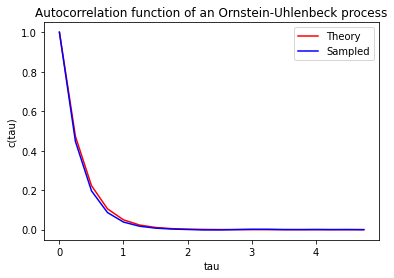

In [6]:
#Plot the autocorrelation function
plt.figure(5)
plt.plot(t,np.exp(-alpha*t),'r',t,C2[nsteps-1:]/C2[nsteps-1],'b')
plt.xlabel('tau')
plt.ylabel('c(tau)')
plt.legend(['Theory','Sampled'])
plt.title('Autocorrelation function of an Ornstein-Uhlenbeck process')
plt.show()

In [7]:
from ou_calibrate_ls import ou_calibrate_ls
from ou_calibrate_ml import ou_calibrate_ml

X2=X[1,:]
muLS,sigmaLS,alphaLS=ou_calibrate_ls(X2,dt)
muML,sigmaML,alphaML=ou_calibrate_ml(X2,dt)

print('IN '+'mu '+str(mu)+' alpha '+str(alpha)+' sigma '+str(sigma))
print('LS '+'mu '+str(np.round(muLS,3))+' alpha '+str(np.round(alphaLS,3))+' sigma '+str(np.round(sigmaLS,3)))
print('ML '+'mu '+str(np.round(muML,3))+' alpha '+str(np.round(alphaML,3))+' sigma '+str(np.round(sigmaML,3)))

IN mu 1 alpha 3 sigma 0.5
LS mu 1.021 alpha 3.603 sigma 0.706
ML mu 1.021 alpha 3.603 sigma 0.67
